for an example of xarray in use https://github.com/weiji14/deepicedrain/blob/atl11_play/atl11_play.ipynb
to plot use https://hvplot.holoviz.org/

In [15]:

import rasterio as rio
import rasterio.mask
import fiona
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from scipy import interpolate
import xarray as xr
from shapely.geometry import Point
import hvplot.xarray  # noqa
import cartopy.crs as crs


In [3]:
path = "/Volumes/arc_02/REMOTE_SENSING/ICESAT2/kamb_atl11_subset.nc"


In [4]:
ds = xr.open_dataset(path, engine="h5netcdf")

In [5]:
ds

<xarray.Dataset>
Dimensions:                      (cycle_number: 6, poly_exponent_x: 8, poly_exponent_y: 8, ref_pt: 1512084)
Coordinates:
  * cycle_number                 (cycle_number) int64 1 2 3 4 5 6
  * poly_exponent_x              (poly_exponent_x) int64 1 0 2 1 0 3 2 1
  * poly_exponent_y              (poly_exponent_y) int64 0 1 0 1 2 0 1 2
  * ref_pt                       (ref_pt) int64 1533075 1533096 ... 1475760
    x                            (ref_pt) float64 ...
    y                            (ref_pt) float64 ...
Data variables:
    at_slope                     (ref_pt) float64 ...
    complex_surface_flag         (ref_pt) float64 ...
    curvature                    (ref_pt) float64 ...
    deg_x                        (ref_pt) float64 ...
    deg_y                        (ref_pt) float64 ...
    delta_time                   (ref_pt, cycle_number) timedelta64[ns] ...
    dem_h                        (ref_pt) float64 ...
    e_slope                      (ref_pt) float64 ...
    h_corr                       (ref_pt, cycle_number) float64 ...
    h_corr_sigma                 (ref_pt, cycle_number) float64 ...
    h_corr_sigma_systematic      (ref_pt, cycle_number) float64 ...
    latitude                     (ref_pt) float64 ...
    longitude                    (ref_pt) float64 ...
    misfit_RMS                   (ref_pt) float64 ...
    misfit_chi2r                 (ref_pt) float64 ...
    n_slope                      (ref_pt) float64 ...
    poly_coeffs                  (ref_pt, poly_exponent_x) float64 ...
    poly_coeffs_sigma            (ref_pt, poly_exponent_x) float64 ...
    quality_summary_corrected_h  (ref_pt, cycle_number) float64 ...
    quality_summary_ref_surf     (ref_pt) float64 ...
    rgt_azimuth                  (ref_pt) float64 ...
    slope_change_rate_x          (ref_pt) float64 ...
    slope_change_rate_x_sigma    (ref_pt) float64 ...
    slope_change_rate_y          (ref_pt) float64 ...
    slope_change_rate_y_sigma    (ref_pt) float64 ...
    utc_time                     (ref_pt, cycle_number) datetime64[ns] ...
    x_atc                        (ref_pt) float64 ...
    xt_slope                     (ref_pt) float64 ...
    y_atc                        (ref_pt) float64 ...
Attributes:
    poly_exponent_x:  [1 0 2 1 0 3 2 1]
    poly_exponent_y:  [0 1 0 1 2 0 1 2]
    slope_change_t0:  29548800

In [6]:
#note, after doing this, cycle 1 is dfs[0]
dfs = []
for cycle_number in range(1,ds.cycle_number.shape[0]+1):
    dfs.append( ds.drop_dims(['poly_exponent_x','poly_exponent_y']).sel(cycle_number=cycle_number).to_dataframe() )

In [7]:
for i,df in enumerate(dfs):
    print( f"cycle {i+1} lasts from {df.utc_time.min()} to {df.utc_time.max()}" )

cycle 1 lasts from 2018-10-14 10:38:12.961094706 to 2018-12-28 08:26:01.844585766
cycle 2 lasts from 2018-12-29 07:59:44.243750826 to 2019-03-29 04:05:55.414784051
cycle 3 lasts from 2019-03-29 16:43:35.713908426 to 2019-06-26 13:15:07.004565224
cycle 4 lasts from 2019-07-27 10:59:12.354397446 to 2019-09-26 19:25:25.030875386
cycle 5 lasts from 2019-10-12 07:55:09.668957442 to 2019-12-25 04:34:41.129356562
cycle 6 lasts from 2020-01-25 02:18:55.537329630 to 2020-03-06 11:26:41.575349286


In [39]:
ds.drop_dims(['poly_exponent_x','poly_exponent_y']).h_corr.sel(cycle_number=slice(1, 7)).to_dataframe()

x              y      h_corr
ref_pt  cycle_number                                          
1533075 1            -411541.944172 -425769.689841         NaN
        2            -411541.944172 -425769.689841         NaN
        3            -411541.944172 -425769.689841  565.779350
        4            -411541.944172 -425769.689841         NaN
        5            -411541.944172 -425769.689841  565.917109
...                             ...            ...         ...
1475760 2            -412145.931245 -432915.288475         NaN
        3            -412145.931245 -432915.288475         NaN
        4            -412145.931245 -432915.288475         NaN
        5            -412145.931245 -432915.288475         NaN
        6            -412145.931245 -432915.288475         NaN

[9072504 rows x 3 columns]

In [37]:
air_ds = xr.tutorial.open_dataset('air_temperature').load()
air_ds.to_dataframe()

air
lat  lon   time                           
75.0 200.0 2013-01-01 00:00:00  241.199997
           2013-01-01 06:00:00  242.099991
           2013-01-01 12:00:00  242.299988
           2013-01-01 18:00:00  241.889999
           2013-01-02 00:00:00  243.199997
...                                    ...
15.0 330.0 2014-12-30 18:00:00  296.089996
           2014-12-31 00:00:00  295.489990
           2014-12-31 06:00:00  295.790009
           2014-12-31 12:00:00  295.190002
           2014-12-31 18:00:00  295.690002

[3869000 rows x 1 columns]

In [25]:
air_ds.air.isel(time=slice(0, 9, 3))

<xarray.DataArray 'air' (time: 3, lat: 25, lon: 53)>
array([[[241.2    , 242.5    , 243.5    , ..., 232.79999, 235.5    ,
         238.59999],
        [243.79999, 244.5    , 244.7    , ..., 232.79999, 235.29999,
         239.29999],
        [250.     , 249.79999, 248.89   , ..., 233.2    , 236.39   ,
         241.7    ],
        ...,
        [296.6    , 296.19998, 296.4    , ..., 295.4    , 295.1    ,
         294.69998],
        [295.9    , 296.19998, 296.79   , ..., 295.9    , 295.9    ,
         295.19998],
        [296.29   , 296.79   , 297.1    , ..., 296.9    , 296.79   ,
         296.6    ]],

       [[241.89   , 241.79999, 241.79999, ..., 234.39   , 235.5    ,
         237.59999],
        [246.29999, 245.29999, 244.2    , ..., 230.89   , 231.5    ,
         234.5    ],
        [256.6    , 254.7    , 252.09999, ..., 230.7    , 231.79999,
         236.09999],
        ...,
        [296.6    , 296.4    , 296.     , ..., 296.5    , 295.79   ,
         295.29   ],
        [297.     , 297.5    , 297.1    , ..., 296.79   , 296.6    ,
         296.29   ],
        [297.5    , 297.69998, 297.5    , ..., 297.79   , 298.     ,
         297.9    ]],

       [[243.29999, 243.29999, 243.09999, ..., 240.2    , 242.39   ,
         244.79999],
        [249.5    , 249.     , 247.89   , ..., 237.59999, 238.29999,
         240.09999],
        [253.59999, 252.     , 250.     , ..., 239.     , 240.09999,
         242.79999],
        ...,
        [295.79   , 295.1    , 294.9    , ..., 296.29   , 295.79   ,
         295.19998],
        [296.69998, 296.29   , 295.69998, ..., 296.69998, 296.9    ,
         296.19998],
        [297.69998, 297.29   , 296.69998, ..., 297.1    , 296.9    ,
         297.1    ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2013-01-02T12:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [24]:
air_ds.air.isel(time=slice(0, 9, 3)).hvplot.quadmesh(
    'lon', 'lat', cmap='viridis', rasterize=True, 
    frame_width=500)

:DynamicMap   [time]
   :Image   [lon,lat]   (air)

In [38]:
geometry = [Point(xy) for xy in zip(df6.x, df6.y)]
df6 = gpd.GeoDataFrame(df6, geometry=geometry,crs="EPSG:3031" )

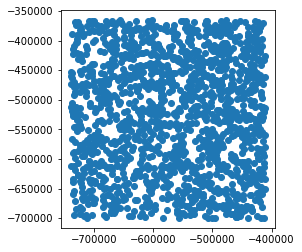

In [41]:
df6.iloc[::1000]-.plot()

ref_pt
1533075   NaN
1533096   NaN
1533099   NaN
1533114   NaN
1533144   NaN
           ..
1475223   NaN
1475391   NaN
1475745   NaN
1475748   NaN
1475760   NaN
Name: h_corr, Length: 1512084, dtype: float64

In [95]:
kamb_dataset.isel(cycle_number=0)

,Array,Chunk
Bytes,12.10 MB,117.65 kB
Shape,"(1512084,)","(14706,)"
Count,14283 Tasks,612 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,12.10 MB,117.65 kB
Shape,"(1512084,)","(14706,)"
Count,14283 Tasks,612 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [27]:
# Convention for import to get shortened namespace
import numpy as np
import xarray as xr

# Create some sample "temperature" data
data = 283 + 5 * np.random.randn(5, 3, 4)
data

array([[[286.01978843, 280.41866042, 286.39948574, 285.77030043],
        [279.28119139, 281.88808899, 275.73558506, 280.22772467],
        [290.34090603, 285.5696655 , 284.62658583, 278.08145282]],

       [[283.96882973, 285.52884397, 285.19757622, 280.01366947],
        [282.48331045, 279.11150541, 278.9426567 , 280.86160717],
        [270.68944199, 283.75915338, 293.51426502, 282.42491709]],

       [[283.65256871, 275.63106705, 286.51520868, 280.8904092 ],
        [271.54022417, 272.95353947, 282.02736681, 281.97422228],
        [283.49306876, 280.86064253, 287.28009572, 284.4680849 ]],

       [[283.9027101 , 287.86121232, 280.30405846, 286.65615436],
        [277.14298157, 281.95718377, 288.57257721, 278.92912523],
        [281.71631387, 278.53623993, 277.76227027, 288.04179377]],

       [[289.94025106, 288.44528399, 278.63153227, 281.8701529 ],
        [287.1421786 , 288.79251451, 284.13808969, 272.67727855],
        [275.68010775, 283.51670855, 290.21906126, 272.87127144]]])

In [ ]:
temp = xr.DataArray(data)
temp

In [28]:
temp = xr.DataArray(data, dims=['time', 'lat', 'lon'])
temp

<xarray.DataArray (time: 5, lat: 3, lon: 4)>
array([[[286.01978843, 280.41866042, 286.39948574, 285.77030043],
        [279.28119139, 281.88808899, 275.73558506, 280.22772467],
        [290.34090603, 285.5696655 , 284.62658583, 278.08145282]],

       [[283.96882973, 285.52884397, 285.19757622, 280.01366947],
        [282.48331045, 279.11150541, 278.9426567 , 280.86160717],
        [270.68944199, 283.75915338, 293.51426502, 282.42491709]],

       [[283.65256871, 275.63106705, 286.51520868, 280.8904092 ],
        [271.54022417, 272.95353947, 282.02736681, 281.97422228],
        [283.49306876, 280.86064253, 287.28009572, 284.4680849 ]],

       [[283.9027101 , 287.86121232, 280.30405846, 286.65615436],
        [277.14298157, 281.95718377, 288.57257721, 278.92912523],
        [281.71631387, 278.53623993, 277.76227027, 288.04179377]],

       [[289.94025106, 288.44528399, 278.63153227, 281.8701529 ],
        [287.1421786 , 288.79251451, 284.13808969, 272.67727855],
        [275.68010775, 283.51670855, 290.21906126, 272.87127144]]])
Dimensions without coordinates: time, lat, lon

In [34]:
temp.isel(time=0)

<xarray.DataArray (lat: 3, lon: 4)>
array([[286.01978843, 280.41866042, 286.39948574, 285.77030043],
       [279.28119139, 281.88808899, 275.73558506, 280.22772467],
       [290.34090603, 285.5696655 , 284.62658583, 278.08145282]])
Dimensions without coordinates: lat, lon

In [41]:
x=1